### LSTM

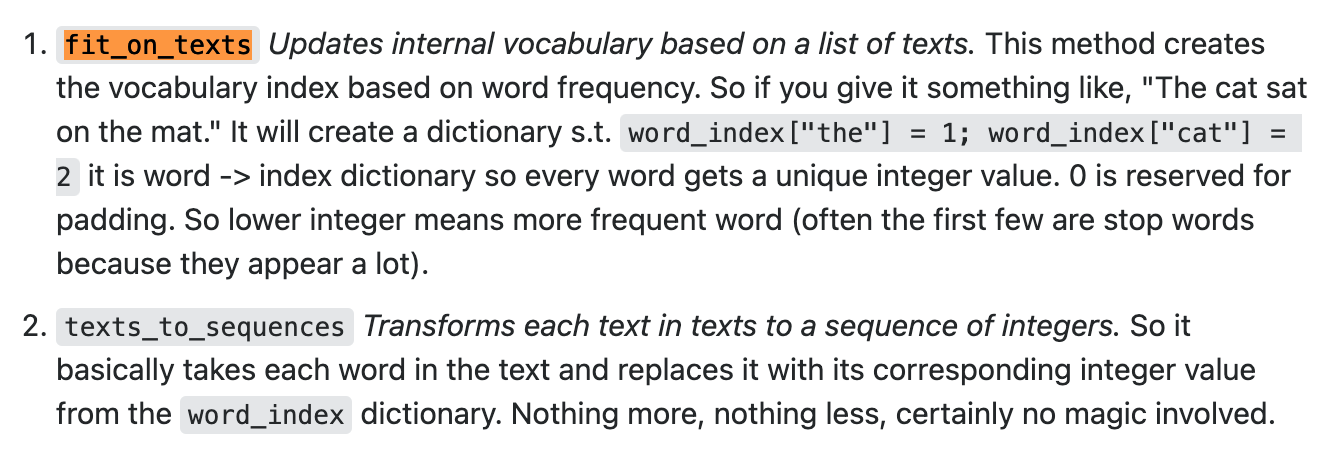

sentence1: nothing more nothing less nothing
sentence2: more than something 

fits_on_text

word_index{
    "nothing": 1,
    
    "more": 2,
    "less": 3,
    "than": 4,
    "something": 5,
}    

seqences: 
[1 2 1 3 1
 2 4 5 4 5]


In [1]:
import keras
from keras.utils import np_utils
from keras.models import Model
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.regularizers import L1L2

import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid, train_test_split

import os
import numpy as np
import pandas as pd

import numpy as np

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding

import random


os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
from load_data import *
clean_tweets_dict = get_all_clean_tweets_dict()

In [3]:
clean_tweets_dict["BarackObama"].head()

,Text,Cleaned
0,One of the things I’ve always loved about bask...,one things ’ always loved basketball fact brin...
1,"COVID-19 has gotten more contagious, so it’s m...",covid19 gotten contagious ’ important ever get...
2,Bob Moses was a hero of mine. His quiet confid...,bob moses hero mine quiet confidence helped sh...
3,I could not be prouder of the incredible athle...,could prouder incredible athletes representing...
4,Since Bruce @springsteen and I first sat down ...,since bruce first sat record podcast renegades...


In [4]:
import re, string

def removeUp(text):
    return re.sub(r'’', '', text)

In [13]:
def generateModel(clean_tweets, input_length = 40, verbose = False):
    
    clean_tweets = list(filter(None, clean_tweets))
    clean_tweets = [x for x in clean_tweets if isinstance(x, str)]
    clean_tweets = [removeUp(x) for x in clean_tweets]

    # step 1: joining all tweets
    clean_tweets = " ".join(clean_tweets)
    
    # step 2: generating tokens
    tokens = clean_tweets.split()
    
    # step 3: generating lines
    length = input_length + 1 # each line will be 101 words long, 100 as input and 1 as output for that line
    lines = []
    
    for i in range(length, len(tokens) + 1):
        seq = tokens[i-length:i]
        line = ' '.join(seq)
        lines.append(line)
        
    # step 4: creating tokenizer and sequences
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    sequences = tokenizer.texts_to_sequences(lines)
    sequences = np.array(sequences)
    
    # step 5: creating X and y
    X, y = sequences[:, :-1], sequences[:,-1]
    
    # step 6: transforming y to categorical output
    vocab_size = len(tokenizer.word_index) + 1
    y = to_categorical(y, num_classes=vocab_size)
    

    # step 7: creating neural network with LSTM model
    model = Sequential()
    model.add(Embedding(vocab_size, input_length, input_length=input_length))
    model.add(LSTM(100, return_sequences=True))
    model.add(LSTM(100))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(vocab_size, activation='softmax'))
    
    # step 8: display summary of model
    if verbose: 
        model.summary()

    # step 9: training model with data X and y
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.fit(X, y, batch_size = 256, epochs = 300, verbose=verbose)

    return model, tokenizer, random.choice(lines)

In [14]:
# storing LSTM models and tokenizer for each username
models = []
tokenizers = []
seeds = []

def generateFor(username):
    cleaned_tweets = clean_tweets_dict[username]
    tweets = cleaned_tweets["Cleaned"]
    
    print(f'------ generating model for {username} -------')

    model, tokenizer, seed_text = generateModel(tweets, input_length=30, verbose=True)
    models.append(model)
    tokenizers.append(tokenizer)
    seeds.append(seed_text)

generateFor("BarackObama")

------ generating model for BarackObama -------
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 30, 30)            120690    
_________________________________________________________________
lstm_10 (LSTM)               (None, 30, 100)           52400     
_________________________________________________________________
lstm_11 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_11 (Dense)             (None, 4023)              406323    
Total params: 669,913
Trainable params: 669,913
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
65/65 [==============================] - 14s 163ms/ste

In [15]:
# Calling `save('my_model')` creates a SavedModel folder `my_model`.

modelName = "barack_obama_model"
models[0].save(modelName)

reconstructed_model = keras.models.load_model(modelName)


INFO:tensorflow:Assets written to: barack_obama_model/assets


INFO:tensorflow:Assets written to: barack_obama_model/assets


In [16]:
def generate_tweet(model, tokenizer, input_length, initial_text, n_words):
    text = []

    for _ in range(n_words):
        encoded = tokenizer.texts_to_sequences([initial_text])[0]
        encoded = pad_sequences([encoded], maxlen = input_length, truncating='pre')

        y_predict = model.predict_classes(encoded)

        predicted_word = ''
        for word, index in tokenizer.word_index.items():
            if index == y_predict:
                predicted_word = word
                break
        initial_text = initial_text + ' ' + predicted_word
        text.append(predicted_word)
    return ' '.join(text)

In [17]:
generate_tweet(models[0], tokenizers[0], 49, seeds[0], 20)

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'corner country step become mandela listening songs first film nationals podcast dreamers meetings paychecks difference fighting urgency equality celebrates years'